# Wczytujemy dane

In [1]:
import os
import matplotlib.pyplot as plt

import sys
sys.path.append(r'C:\src\mne-python')
import mne

%matplotlib inline

Plik ten sam co ostatnio (`'sternberg_diam_015_AK-epo.fif'`), tym razem wczytajcie go sami. Im mniej pomocy potrzebujecie przy tym (ze strony internetu, innych studentów), tym lepiej.

In [2]:
# wczytujemy
os.chdir(r'C:\Users\swps\Dropbox\Sarenka\ZAJECIA\Analiza Danych EEG 2017 - 2018\dane')
epochs = mne.read_epochs('sternberg_diam_015_AK-epo.fif', preload=True)

Reading sternberg_diam_015_AK-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
281 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
281 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


Tak jak wcześniej - robimy widmo dla warunków l2 i l4, tylko dla elektrod Pz i Fz. Znów - im mniej musicie sięgać do źródeł zewnętrznych względem swojego mózgu - tym lepiej.

In [3]:
# wczytujemy funkcję aby można było się do niej odwoływać
# bezpośrednio - bez całej ścieżki modułu
from mne.time_frequency import psd_welch

# znajdujemy kanały
Pz = epochs.ch_names.index('Pz')
Fz = epochs.ch_names.index('Fz')
ch_idx = [Pz, Fz]

sfreq = epochs.info['sfreq']
psd_l2, freq = psd_welch(epochs['l2'], tmin=0.5, fmax=25.,
                         picks=ch_idx, n_fft=int(sfreq))
psd_l4, freq = psd_welch(epochs['l4'], tmin=0.5, fmax=25.,
                         picks=ch_idx, n_fft=int(sfreq))

Effective window size : 1.000 (s)
Effective window size : 1.000 (s)


I ponownie, tak jak na ostatnich zajęciach, stajemy przed dylematem:
chcemy zdefiniować sobie dwa pasma częstotliwościowe:
* 9 - 11 Hz (tu widać efekt dla elektrod potylicznych)
* 12 - 14 Hz (tu widać efekt dla elektrod czołowych)

Chcemy uśrednić w tych pasmach widmo (ale nie będzimy chcieli uśredniać epok).  
Dodatkowo, chcemy to zrobić zarówno dla elektrody Pz jak i Fz.  
Na początek skupmy się na elektrodzie Pz, paśmie 9 - 11.  
Do szykania zakresów przyda się Wam funkcja z ostatnich zajęć:  

In [4]:
def znajdź_zakres(freq, lo, hi):
    abs_diff_lo = np.abs(freq - lo)
    lo_idx = np.argmin(abs_diff_lo)
    abs_diff_hi = np.abs(freq - hi)
    hi_idx = np.argmin(abs_diff_hi)
    return lo_idx, hi_idx + 1

Przypomnienie: używamy jej tak:

In [5]:
# tworzymy sobie fikcyjny sygnał
import numpy as np
częstotliwości = np.linspace(0, 15, num=29)
print('przykładowy wektor freq:\n', częstotliwości, '\n')

# znajdujemy zkares
l, h = znajdź_zakres(częstotliwości, 8, 10)
print('indeksy zakresu:', l, h)
print('zakres wybrany indeksami:', częstotliwości[l:h])

przykładowy wektor freq:
 [  0.           0.53571429   1.07142857   1.60714286   2.14285714
   2.67857143   3.21428571   3.75         4.28571429   4.82142857
   5.35714286   5.89285714   6.42857143   6.96428571   7.5          8.03571429
   8.57142857   9.10714286   9.64285714  10.17857143  10.71428571  11.25
  11.78571429  12.32142857  12.85714286  13.39285714  13.92857143
  14.46428571  15.        ] 

indeksy zakresu: 15 20
zakres wybrany indeksami: [  8.03571429   8.57142857   9.10714286   9.64285714  10.17857143]


W podobny sposób możemy wybrać jakiś zakres częstotliwościowy oraz go uśrednić.
Pomyślcie jak zrobić średnią dla zakresu 9 - 11 Hz dla widma z elektrody Pz, warunku l2.

In [6]:
# znajdujemy zakres w rzeczywistym wektorze częstotliwości (freq)
l, h = znajdź_zakres(freq, 9, 11)

Teraz wybieramy z `psd_l2`:
* wszystkie epoki (`:`)
* elektrodę Pz (tutaj jest pierwsza, więc `0`)
* znaleziony zakres częstotliwości (`l:h`)  

i zachowujemy w zmiennej `Pz_alpha1_l2`

In [7]:
Pz_alpha1_l2 = psd_l2[..., ..., ...]

# Macierze - powtórka oraz jak jeść gofry w 3D:

Ten kod poniżej jest tylko dla mnie aby Wam pokazać przykład macierzy 3d i 'jak to się je'.  

Nie musicie uruchamiać tego kodu.  
Nie ruszy Wam zresztą jeżeli nie macie zainstalowanego matplotlib'a 2.1.  
Jeżeli koniecznie chcecie go zainstalować aby móc odpalić kod poniżej, wejdźcie do konsoli i wpiszcie tam:  
```
conda update matplotlib
```
zaakceptujcie plan instalacji naciskając `y` a następnie `enter`.  
następnie musicie zrestartować notebook (`Kernel --> Restart Kernel`).

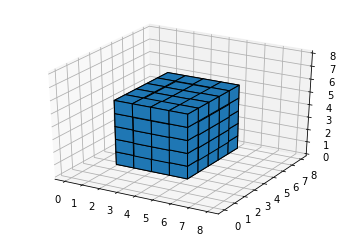

In [8]:
from mpl_toolkits.mplot3d import Axes3D

x, y, z = np.indices((8, 8, 8))
block = (x > 1) & (x < 6) & (y > 0) & (y < 6) & (z > 0) & (z < 6)

def plot_matrix_3d(matrix):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.voxels(matrix, edgecolor='k')

# pełna macierz:
plot_matrix_3d(block)

Wyobraźcie sobie że to są ułożone na sobie gofry tworzące gofrową wieżę.  
Każdy gofr to jedna częstotliwość:
<img src='https://f.wszelkieprzepisy.pl/images/4hf9bocr/gofry-belgijskie-orig.png' width=240 height=180>

W gofrach są kratki - każda kratka odpowiada pewnej epoce (gofrowe wiersze) oraz elektrodzie (gofrowe kolumny).  
W każdej gofrowej "kratce" jest pewna ilość smakołyków, która opisuje jak silna jest moc w tym punkcie  
(czyli dla danego zestawienia epoka, elektroda, częstotliwość):  
<img src='https://www.kwestiasmaku.com/sites/kwestiasmaku.com/files/gofry_domowe_01.jpg' width=240 height=180>

In [9]:
# wybieramy sobie wycinek przestrzeni gdzie są
# niebieskie voxele aby go adresować łatwo:
matrix = block[2:6, 1:6, 1:6]
matrix[:] = False

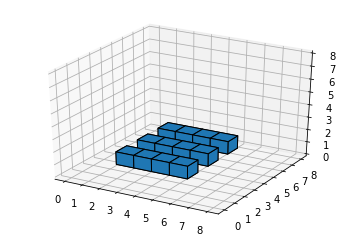

In [10]:
# adresujemy wszystkie 'wiersze' (epoki) i co drugą 'kolumnę' (elektrody),
# ale tylko dla pierwszej 'warstwy' (częstotliwości):
matrix[:, ::2, 0] = True

plot_matrix_3d(block)

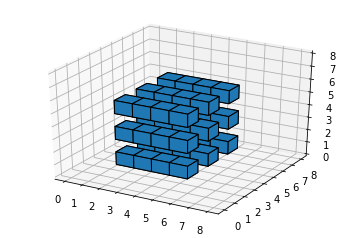

In [11]:
# adresujemy wszystkie 'wiersze' i co drugą 'kolumnę',
# dla co drugiej 'warstwy':
matrix[:, ::2, ::2] = True

plot_matrix_3d(block)

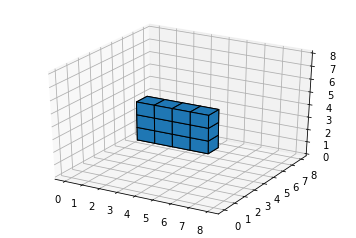

In [12]:
# a teraz wszystkie epoki, tylko jedna elektroda i zakres częstotliwości
matrix[:] = False
matrix[:, 2, 1:4] = True

plot_matrix_3d(block)

# Idziemy dalej
chcemy teraz dla gofrowej wieży `Pz_alpha1_l2` zrobić średnią po częstotliwościach i zapisać w zmiennej `avg_Pz_alpha1_l2`:

In [13]:
avg_Pz_alpha_l2 = Pz_alpha1_l2.mean(axis=-1)

Możemy też zobaczyć sobie histogram:

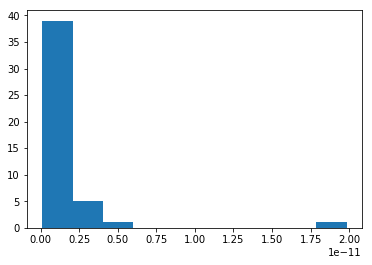

In [14]:
plt.hist(avg_Pz_alpha_l2);

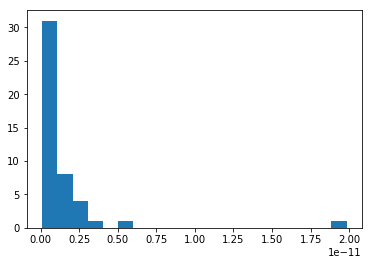

In [15]:
plt.hist(avg_Pz_alpha_l2, bins=20);

Weźcie pod uwagę że rozkład jest bardzo wyraźnie skośny - później przeprowadzimy test również dla zlogarytmizowanych wartości.  
Policzcie więc sobie również `avg_Pz_l4`, a następnie poszukajcie informacji w necie jak zrobić test t dla prób niezależnych
(test przeprowadzamy teraz na epokach z jednej osoby i chociaż epoki pochodzące z tej samej osoby będą do siebie bardziej podobne niż pochodzące od dwóch różnych osób, w kontekście testów wewnątrz osoby możemy je traktować jako niezależne).

In [16]:
# liczymy avg_Pz_l4 i w jednej linijce
avg_Pz_alpha_l4 = psd_l4[:, 0, l:h].mean(axis=-1)

from scipy.stats import ttest_ind
t, p = ttest_ind(avg_Pz_alpha_l4, avg_Pz_alpha_l2)

print('t = {:.3f}; p = {:.3f}'.format(t, p))

t = 2.055; p = 0.043


Gdy wybrzmi już wynik testu, sprawdźmy co się dzieje w sytuacji gdy zlogarytmizujemy nasze zmienne.
Skorzystaj do tego z `np.log` (logarytm naturalny) albo `np.log10` (logarytm o podstawie 10).

In [17]:
t, p = ttest_ind(np.log(avg_Pz_alpha_l4),
                 np.log(avg_Pz_alpha_l2))

print('t = {:.3f}; p = {:.3f}'.format(t, p))

t = 3.246; p = 0.002


Odpowiedz na pytanie: 
> czy wynik testu zmienia się w zależności od logarytmizacji danych?  
> Dlaczego (tak/nie)?

Zanim przejdziemy do ćwiczenia powtózeniowego, zwizualizujmy sobie wyniki. Skorzystamy do tego z bardzo wygodnej biblioteki `seaborn`:

In [18]:
import seaborn as sns

In [19]:
# tworzymy dane do wyświetlenia, musimy zlepić oba warunki
# (l_2 i l_4) w jeden wektor aby łatwo było wyświetlać
all_vals = np.concatenate([avg_Pz_alpha_l2, avg_Pz_alpha_l4])

# tworzymy też etykiety dla każdej wartości (tzn do którego należy warunku)
labels = ['load 2'] * len(avg_Pz_alpha_l2) + ['load 4'] * len(avg_Pz_alpha_l4)

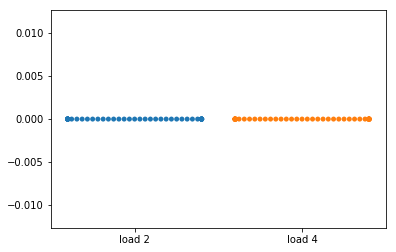

In [20]:
sns.swarmplot(x=labels, y=all_vals)

Niestety seaborn nie daje sobie rady gdy mamy bardzo małe wartości.  
Musimy stworzyć mu panel z odpowiednimi limitami osi, albo przeskalować dane.

In [22]:
minval = all_vals.min()
maxval = all_vals.max()
rng = maxval - minval
print('Zakres danych:\nmin {}\nmax {}'.format(minval, maxval))

Zakres danych:
min 3.305163166786556e-14
max 1.983158060882605e-11


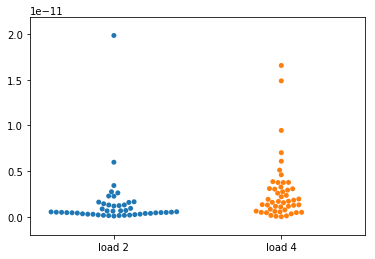

In [23]:
fig, ax = plt.subplots()
ax.set_ylim(minval - 0.1 * rng, maxval + 0.1 * rng)

sns.swarmplot(x=labels, y=all_vals, ax=ax)

Gdy test t widzi taką skośność to jest mu bardzo przykro i mówi z rozżaleniem "Panie i Panowie, nie na to się umawialiśmy!".  
Test t studenta (w opozycji do testu t żołnierza - BTW znacie tę historię?) jest dosyć odporny na odchylenia od założeń o normalności danych,  
ale na takie skośne wariactwa jest czuły. Zobaczmy nasze dane po logarytmizacji:

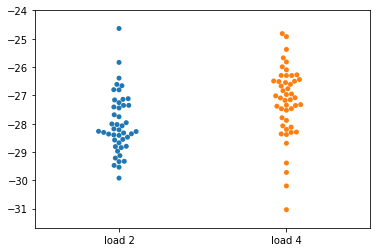

In [24]:
all_vals_log = np.log(all_vals)
minval = all_vals_log.min()
maxval = all_vals_log.max()
rng = maxval - minval

fig, ax = plt.subplots()
ax.set_ylim(minval - 0.1 * rng, maxval + 0.1 * rng)

sns.swarmplot(x=labels, y=all_vals_log, ax=ax)

W wielu przypadkach (np gdy rozkład, który transformujemy to rozkład gamma)  
dane nie będą super normalne (może pojawić się skośność w drugą stronę - tak  
jak w przypadku pomarańczowych punktów), ale będą dużo bliżej rozkładu normalnego.

# Ćwiczenie

Teraz zadania dla Ciebie:
* uśrednij pasmo 9 - 11 Hz dla drugiej elektrody
* przeprowadź test t dla tych wartości (najlepiej zlogarytmizowanych)
* zwizualizuj różnicę
* przeprowadź także testy dla obu elektrod dla drugiego pasma częstotliwościowego (tutaj już bez wykresów)

# Wielokrotne porównania

Co gdybyśmy chcieli wykonać porównania dla każdego punktu widma?

In [25]:
# nie uśredniamy teraz częstotliwości
Pz_l2 = psd_l2[:, 0, :]
Pz_l4 = psd_l4[:, 0, :]

# robimy test t dla axis=0 bo obserwacje (epoki) mamy w pierwszym wymiarze
t_values, p_values = ttest_ind(Pz_l4, Pz_l2, axis=0)

Poniżej wyświetlamy wartości t oraz oznaczamy 'istotne' efekty.  
Używam niżej adresowania logicznego `wektor[inny_wektor < 0.05]` - w ten sposób  
wybieram elementy wektora `wektor` odpowiadające miejscom gdzie inny wektor  
`inny_wektor` ma wartości mniejsze niż `0.05`.  
Nie musi to być dla Was klarowne w każdym razie - w tym wypadku ważniejsze są same wizualizacje.

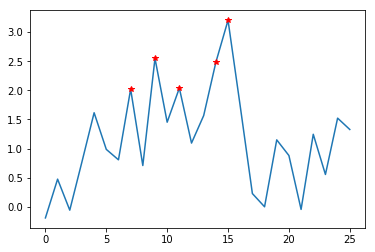

In [27]:
plt.plot(freq, t_values)
plt.plot(freq[p_values < 0.05], t_values[p_values < 0.05], '*', color='r')

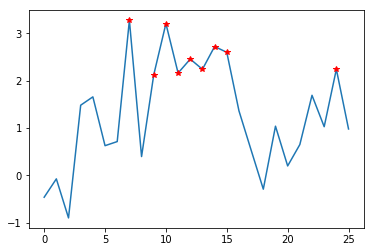

In [28]:
t_values_log, p_values_log = ttest_ind(np.log(Pz_l4), np.log(Pz_l2), axis=0)

plt.plot(freq, t_values_log)
plt.plot(freq[p_values_log < 0.05], t_values_log[p_values_log < 0.05], '*', color='r')

## Interaktywna wizualizacja widma
Tutaj zobaczymy jak skorzystać ze `SpectrumPlot` z mojego pakietu `mypy`  
(głupia nazwa, cóż, ale pakiet nie jest przeznaczenia publicznego, także nikt z tego powodu nie płacze oprócz mnie)

In [12]:
# tutaj możecie spróbować narysować obie linie na raz
epochs2 = epochs.copy()
mne.add_reference_channels(epochs2, 'Cz', copy=False) # verbose !
epochs2.set_eeg_reference(verbose=False, projection=False)

psd_all, freq = psd_welch(epochs2['l4'], tmin=0.5, fmax=25.,
                          n_fft=int(sfreq))

The locations of multiple reference channels are ignored (set to zero).
Applying a custom EEG reference.


<ipython-input-12-ebc4c50a3a79>:3: RuntimeWarning: The locations of multiple reference channels are ignored (set to zero).
  mne.add_reference_channels(epochs2, 'Cz', copy=False) # verbose !


Effective window size : 1.000 (s)


In [13]:
%matplotlib

Using matplotlib backend: Qt5Agg


In [15]:
from mypy.viz import SpectrumPlot

In [17]:
sp = SpectrumPlot(psd_all, freq, epochs2.info)

C:\Anaconda3\lib\site-packages\matplotlib\__init__.py:1710: MatplotlibDeprecationWarning: The *left* kwarg to `bar` is deprecated use *x* instead. Support for *left* will be removed in Matplotlib 3.0
  return func(ax, *args, **kwargs)


## Czas-częstość

In [5]:
import numpy as np
from mne.time_frequency import tfr_morlet

In [6]:
freq = np.arange(3, 20, 0.25)
n_cycles = freq / 2.5

tfr_2 = tfr_morlet(epochs['l2'], freq, n_cycles, use_fft=True,
                   return_itc=False, n_jobs=3)
tfr_4 = tfr_morlet(epochs['l4'], freq, n_cycles, use_fft=True,
                   return_itc=False, n_jobs=3)

[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:    4.8s
[Parallel(n_jobs=3)]: Done  63 out of  63 | elapsed:    8.4s finished
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:    4.7s
[Parallel(n_jobs=3)]: Done  63 out of  63 | elapsed:    8.4s finished


In [9]:
%matplotlib

Using matplotlib backend: Qt5Agg


In [10]:
tfr_2.plot_topo(baseline=(-0.4, -0.1), mode='percent');

Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)


In [11]:
%matplotlib inline

Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)


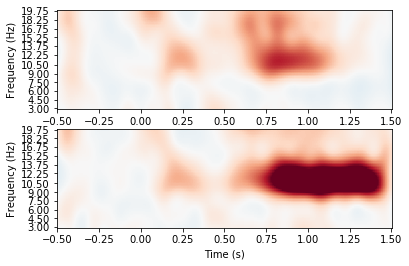

In [12]:
ch = epochs.ch_names.index('PO3')

fig, ax = plt.subplots(nrows=2)
tfr_2.plot([ch], baseline=(-0.4, -0.1), mode='percent', axes=ax[0], show=False,
           vmin=-5, vmax=5, colorbar=False);
tfr_4.plot([ch], baseline=(-0.4, -0.1), mode='percent', axes=ax[1],
           vmin=-5, vmax=5, colorbar=False);